In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

ROOT_DIR = os.getcwd()

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom
%matplotlib inline

Using TensorFlow backend.


In [2]:
config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "datasets")
print(CUSTOM_DIR)

/Users/ethan/MyCodes/video_clip_ocr/Mask_RCNN/datasets


In [3]:
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "train")

dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 46
Class Count: 2
  0. BG                                                
  1. score_card                                        


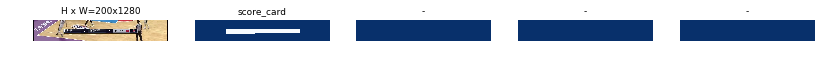

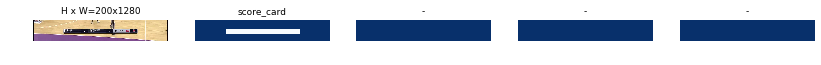

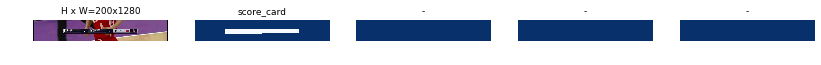

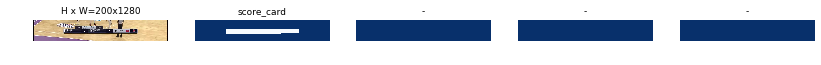

In [4]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id 37 /Users/ethan/MyCodes/video_clip_ocr/Mask_RCNN/datasets/train/00023900.jpg
image                    shape: (200, 1280, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (200, 1280, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   89.00000  max:  991.00000  int32


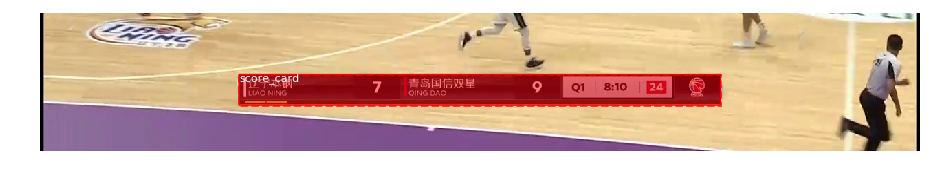

In [5]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

print("image_id", image_id, dataset.image_reference(image_id))
log('image', image)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  15 /Users/ethan/MyCodes/video_clip_ocr/Mask_RCNN/datasets/train/00023175.jpg
Original shape:  (200, 1280, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  233.00000  max:  791.00000  int32


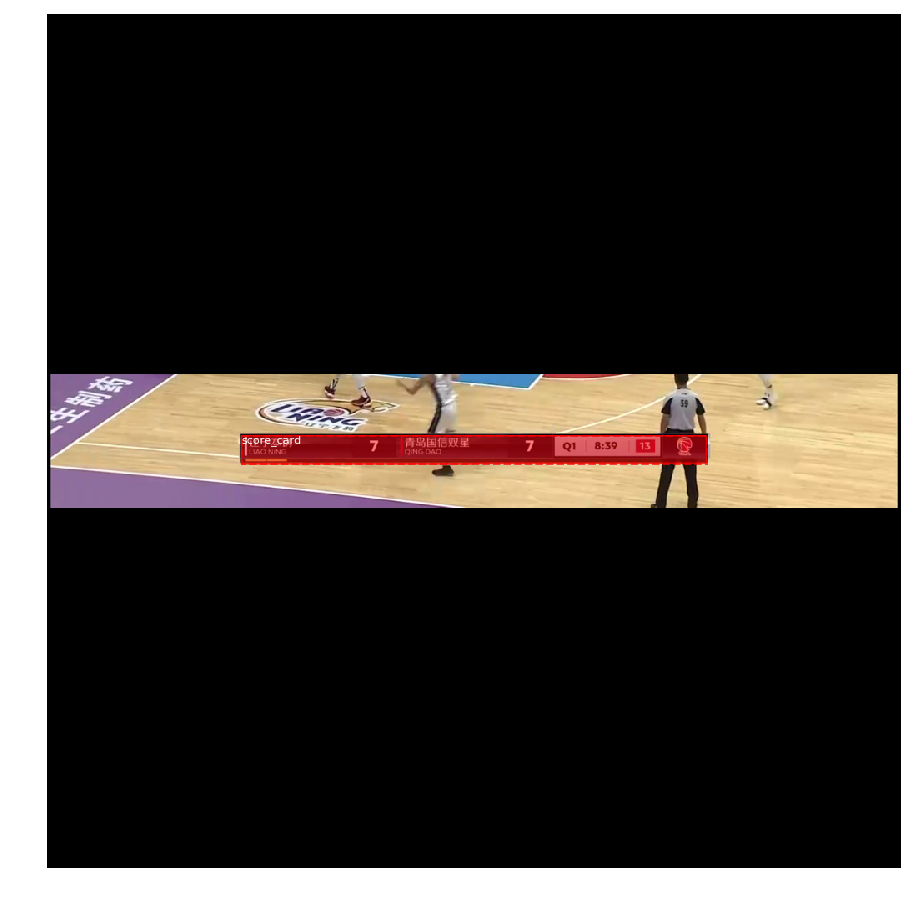

In [6]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

image, window, scale, padding, _ = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
bbox = utils.extract_bboxes(mask)

print('image_id: ', image_id, dataset.image_reference(image_id))
print('Original shape: ', original_shape)
log('image', image)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1280.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  232.00000  max:  791.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


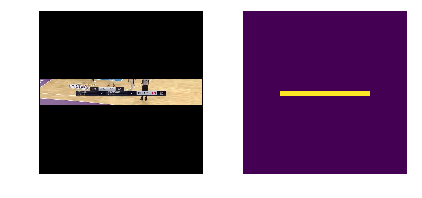

In [7]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log('image', image)
log('image_meta', image_meta)
log('class_ids', class_ids)
log('bbox', bbox)
log('mask', mask)

display_images([image] + [mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

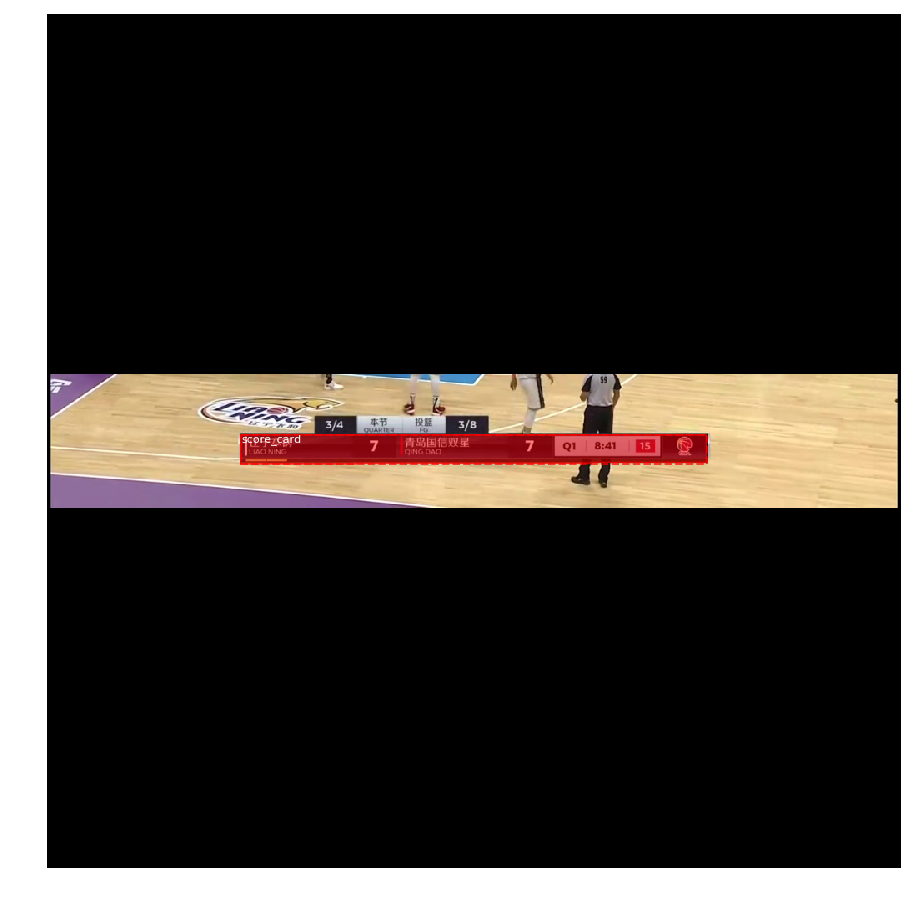

In [8]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


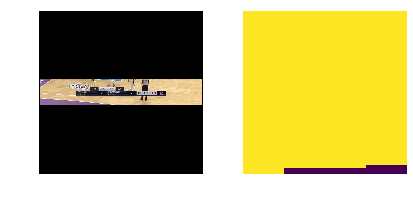

In [9]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log('mask', mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

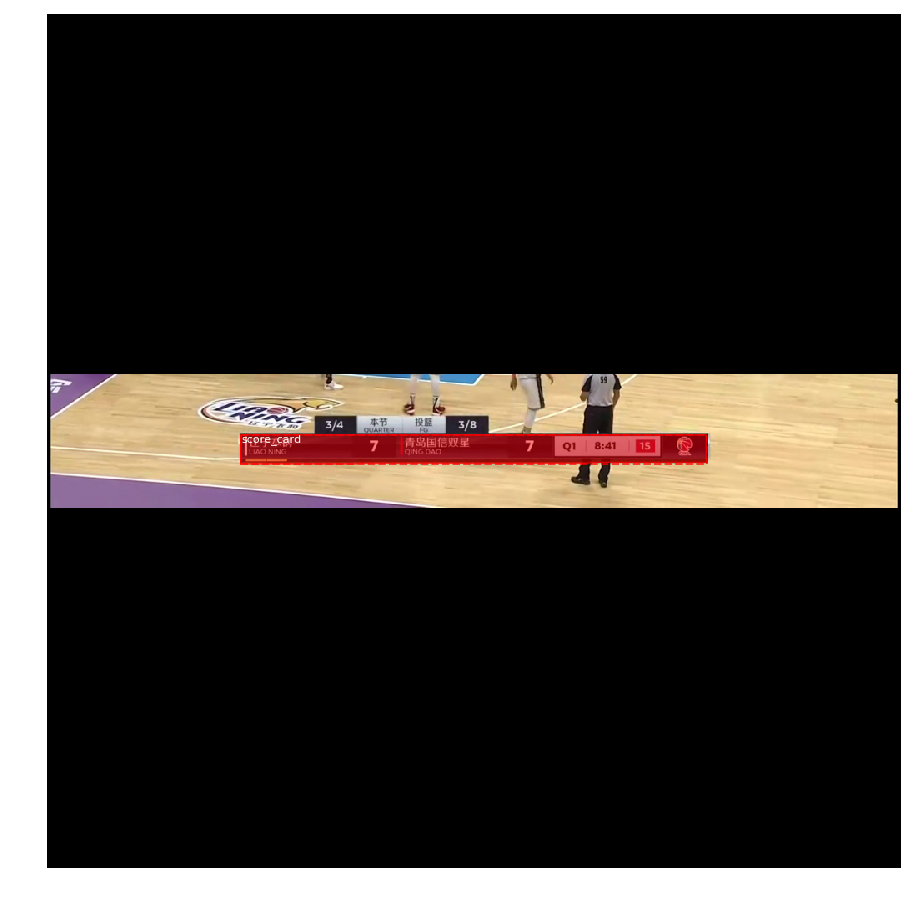

In [10]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [11]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768
